## original error report

Inputs

```
ra_cen = 6.128
dec_cen = -72.090
radius = 1.0 
query = """
        SELECT visitId, ra, dec, band, pixelScale, psfSigma, magLim
        FROM dp1_v29.CcdVisit 
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        ORDER BY visitId 
        """.format(ra_cen, dec_cen, radius)
job = service.submit_job(query)
ccdtab = job.fetch_result().to_table()

# Compute and add a new column
ccdtab['psf_fwhm'] = 2*np.sqrt(2.0*np.log(2))*ccdtab['pixelScale'].value*ccdtab['psfSigma'].value

# Print unique psfSigma values and a median value
print(np.unique(ccdtab[(ccdtab['psf_fwhm']< 0.6) & (ccdtab['psf_fwhm']>0.3) & (ccdtab['band'] == 'r')]['psfSigma']))
print(np.nanmedian(ccdtab[(ccdtab['psf_fwhm']< 0.6) & (ccdtab['psf_fwhm']>0.3) & (ccdtab['band'] == 'r')]['psfSigma']))

# Print unique psf_fwhm values and a median value
print(np.unique(ccdtab[(ccdtab['psf_fwhm']< 0.6) & (ccdtab['psf_fwhm']>0.3) & (ccdtab['band'] == 'r')]['psf_fwhm']))
print(np.nanmedian(ccdtab[(ccdtab['psf_fwhm']< 0.6) & (ccdtab['psf_fwhm']>0.3) & (ccdtab['band'] == 'r')]['psf_fwhm']))

```

**RESULTS**
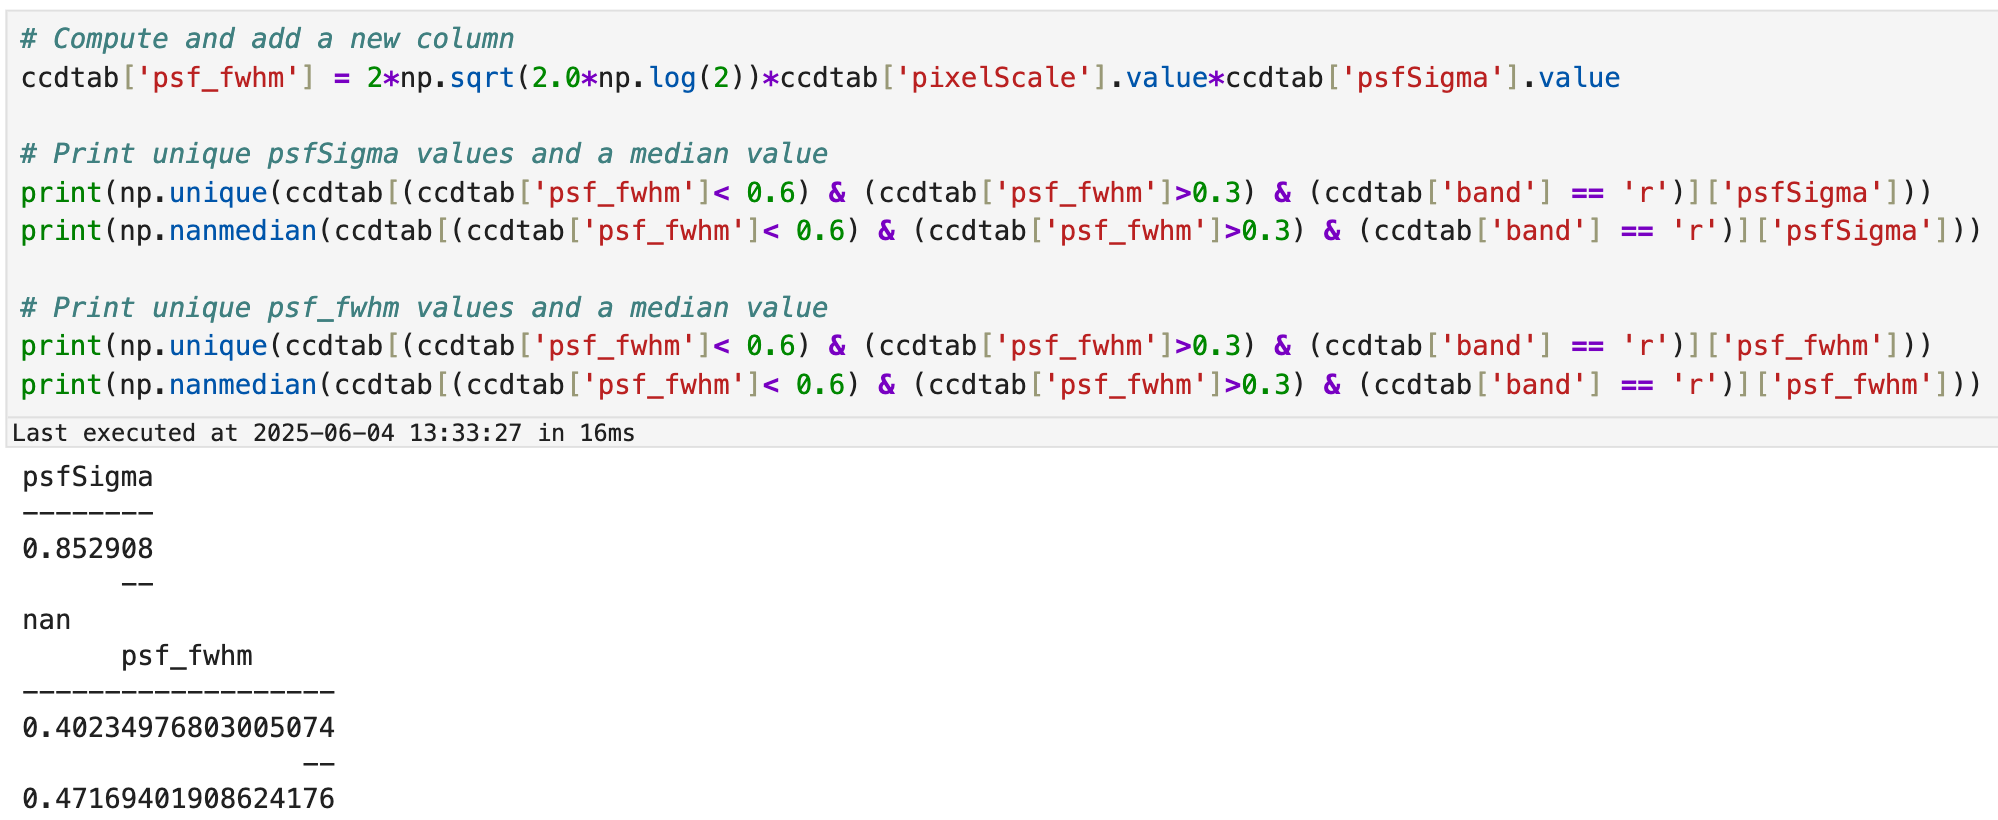


Essentially, it seemed like null/nan were being "converted" to values and that was very worrying.

Can't reproduce that in this NB but do want to explore masked array failure modes.

Starting point: Melissa's testing NB: https://github.com/lsst/cst-dev/blob/main/MLG_sandbox/DP1/issues/masked_array_nanmedian.ipynb.

In [1]:
import numpy as np
from lsst.rsp import get_tap_service
import astropy
import scipy.stats.mstats as scistats

In [2]:
service = get_tap_service("tap")
assert service is not None

In [17]:
np.__version__

'2.2.6'

## get the same data as YC originally used

In [3]:
ra_cen = 6.128
dec_cen = -72.090
radius = 1.0 
query = """
        SELECT psfSigma
        FROM dp1.CcdVisit 
        WHERE CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS', {}, {}, {}))=1
        """.format(ra_cen, dec_cen, radius)

In [4]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [5]:
results = job.fetch_result()

In [6]:
ccd_visits = results.to_table()

In [7]:
results['psfSigma'].dtype, ccd_visits['psfSigma'].dtype

(dtype('float32'), dtype('float32'))

In [12]:
# ccd_visits['psfSigma']

# With Numpy

In [14]:
# Define the data sources for clarity
data_sources = {
    "Raw Query": results['psfSigma'],
    "Astropy Table": ccd_visits['psfSigma']
}

## 1. Mean

Compare how standard, NaN-aware, and masked array reduction methods affect the calculated mean of psfSigma for both raw query results and Astropy tables.

In [15]:
print(f"{'Source':<15} | {'Method':<20} | {'Result':<22} | {'dtype'}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard Mean
    print(f"{name:<15} | np.mean              | {np.mean(data):.20f} | {type(np.mean(data))}")
    
    # 2. NaN Mean
    print(f"{name:<15} | np.nanmean           | {np.nanmean(data):.20f} | {type(np.nanmean(data))}")
    
    # 3. Masked Mean
    print(f"{name:<15} | np.ma.mean           | {np.ma.mean(data):.20f} | {type(np.ma.mean(data))}")
    
    # 4. Compressed Mean
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | .compressed().mean() | {np.mean(data.compressed()):.20f} | {type(np.mean(data.compressed()))}")
    print("-" * 90)

Source          | Method               | Result                 | dtype
------------------------------------------------------------------------------------------
Raw Query       | np.mean              | 2.65416754138675603514 | <class 'numpy.float64'>
Raw Query       | np.nanmean           | 2.65416765213012695312 | <class 'numpy.float32'>
Raw Query       | np.ma.mean           | 2.65416754138675603514 | <class 'numpy.float64'>
Raw Query       | .compressed().mean() | 2.65416789054870605469 | <class 'numpy.float32'>
------------------------------------------------------------------------------------------
Astropy Table   | np.mean              | 2.65416754138675603514 | <class 'numpy.float64'>
Astropy Table   | np.nanmean           | 2.65416765213012695312 | <class 'numpy.float32'>
Astropy Table   | np.ma.mean           | 2.65416754138675603514 | <class 'numpy.float64'>
Astropy Table   | .compressed().mean() | 2.65416789054870605469 | <class 'numpy.float32'>
--------------------------

**Conclusion:** Computing the mean of a masked array works correctly across these methods, but the results differ slightly due to the `np.float32` data type of the input array. These discrepancies occur because different functions sum the data in different orders (e.g., contiguous vs. strided memory access). Since floating-point addition is non-associative (i.e., (A+B)+C $\neq$ A+(B+C)), the accumulation order changes the final result at the limit of precision. The behavior is identical for both the "Raw Query" and the "Astropy Table," confirming this is a fundamental NumPy interaction issue, not a container issue.

**Recommendation for the users:** Let the users choose, based on the dtype of an input array!

## 2. Median

Compare how standard, NaN-aware, and masked array reduction methods affect the calculated median of `psfSigma` for both raw query results and `Astropy` tables.

In [16]:
print(f"{'Source':<15} | {'Method':<22} | {'dtype':23} | {'Result':<22}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard Median
    print(f"{name:<15} | {'np.median':<22} | {type(np.median(data))} | {np.median(data):.20f}")
    
    # 2. NaN Median
    print(f"{name:<15} | {'np.nanmedian':<22} | {type(np.nanmedian(data))} | {np.nanmedian(data):.20f}")
    
    # 3. Masked Median
    print(f"{name:<15} | {'np.ma.median':<22} | {type(np.ma.median(data))} | {np.ma.median(data):.20f}")
    
    # 4. Compressed Median
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | {'.compressed().median()':<22} | {type(np.median(data.compressed()))} | {np.median(data.compressed()):.20f}")
    print("-" * 90)

Source          | Method                 | dtype                   | Result                
------------------------------------------------------------------------------------------
Raw Query       | np.median              | <class 'numpy.float32'> | nan
Raw Query       | np.nanmedian           | <class 'numpy.float32'> | nan
Raw Query       | np.ma.median           | <class 'numpy.float32'> | 2.58667993545532226562
Raw Query       | .compressed().median() | <class 'numpy.float32'> | 2.58667993545532226562
------------------------------------------------------------------------------------------
Astropy Table   | np.median              | <class 'numpy.float32'> | nan
Astropy Table   | np.nanmedian           | <class 'numpy.float32'> | nan
Astropy Table   | np.ma.median           | <class 'numpy.float32'> | 2.58667993545532226562
Astropy Table   | .compressed().median() | <class 'numpy.float32'> | 2.58667993545532226562
------------------------------------------------------------------

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


**Conclusion:** Both `np.median` and `np.nanmedian` returned `nan`. This indicates that these functions stripped the mask, accessed the underlying "bad" data (likely `NaN` or invalid floating-point values), and allowed those values to propagate, destroying the result. Both `np.ma.median` and the `.compressed()` method correctly respected the mask, excluding invalid pixels/rows, and returned the correct result (precision is still something to be cautious about).

**Recommendataion for the users:** Always trust the mask! Use either `np.ma.median(data)` or `np.median(data.compressed())`.

## 3. Percentile & Quantile

Compare how standard, NaN-aware, and masked array reduction methods affect the calculated percentile & quantile of `psfSigma` for both raw query results and `Astropy` tables.

In [11]:
print(f"{'Source':<15} | {'Method':<27} | {'dtype':23} | {'Result':<22}")
print("-" * 97)

for name, data in data_sources.items():
    # 1. Standard Percentile
    print(f"{name:<15} | {'np.percentile':<27} | {type(np.percentile(data, 50))} | {np.percentile(data, 50):.20f}")
    
    # 2. NaN Percentile
    print(f"{name:<15} | {'np.nanpercentile':<27} | {type(np.nanpercentile(data, 50))} | {np.nanpercentile(data, 50):.20f}")
    
    # 3. Masked Percentile
    print(f"{name:<15} | {'np.ma.percentile':<27} | {'Not available':<23} | {'Not available':<23}")
    
    # 4. Compressed Percentile
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | {'.compressed().percentile()':<27} | {type(np.percentile(data.compressed(), 50))} | {np.percentile(data.compressed(), 50):.20f}")
    print("-" * 97)

Source          | Method                      | dtype                   | Result                
-------------------------------------------------------------------------------------------------
Raw Query       | np.percentile               | <class 'numpy.float32'> | nan
Raw Query       | np.nanpercentile            | <class 'numpy.float32'> | nan
Raw Query       | np.ma.percentile            | Not available           | Not available          
Raw Query       | .compressed().percentile()  | <class 'numpy.float32'> | 2.58667993545532226562
-------------------------------------------------------------------------------------------------
Astropy Table   | np.percentile               | <class 'numpy.float32'> | nan
Astropy Table   | np.nanpercentile            | <class 'numpy.float32'> | nan
Astropy Table   | np.ma.percentile            | Not available           | Not available          
Astropy Table   | .compressed().percentile()  | <class 'numpy.float32'> | 2.58667993545532226562
-----

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


In [12]:
print(f"{'Source':<15} | {'Method':<27} | {'dtype':23} | {'Result':<22}")
print("-" * 97)

for name, data in data_sources.items():
    # 1. Standard Percentile
    print(f"{name:<15} | {'np.quantile':<27} | {type(np.quantile(data, 0.5))} | {np.quantile(data, 0.5):.20f}")
    
    # 2. NaN Percentile
    print(f"{name:<15} | {'np.nanquantile':<27} | {type(np.nanquantile(data, 0.5))} | {np.nanquantile(data, 0.5):.20f}")
    
    # 3. Masked Percentile
    print(f"{name:<15} | {'np.ma.quantile':<27} | {'Not available':<23} | {'Not available':<23}")
    
    # 4. Compressed Percentile
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | {'.compressed().quantile()':<27} | {type(np.quantile(data.compressed(), 0.5))} | {np.quantile(data.compressed(), 0.5):.20f}")
    print("-" * 97)

Source          | Method                      | dtype                   | Result                
-------------------------------------------------------------------------------------------------
Raw Query       | np.quantile                 | <class 'numpy.float32'> | nan
Raw Query       | np.nanquantile              | <class 'numpy.float32'> | nan
Raw Query       | np.ma.quantile              | Not available           | Not available          
Raw Query       | .compressed().quantile()    | <class 'numpy.float32'> | 2.58667993545532226562
-------------------------------------------------------------------------------------------------
Astropy Table   | np.quantile                 | <class 'numpy.float32'> | nan
Astropy Table   | np.nanquantile              | <class 'numpy.float32'> | nan
Astropy Table   | np.ma.quantile              | Not available           | Not available          
Astropy Table   | .compressed().quantile()    | <class 'numpy.float32'> | 2.58667993545532226562
-----

**Conclusion:** Just like the median test, `np.quantile` and `np.nanquantile` fail because they ignore the mask and ingest invalid underlying data (returning `NaN`). Unlike median, the `numpy.ma` module does not have a `quantile` (or `percentile`) function. Users looking for `np.ma.quantile` will find it doesn't exist. The **only** successful approach was performing the operation on compressed data.

**Recommendation for the users:** Compress before doing `percentile` or `quantile`.

## 4. Min/Max

In [13]:
print(f"{'Source':<15} | {'Method':<20} | {'Result':<22} | {'dtype'}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard Mean
    print(f"{name:<15} | np.min              | {np.min(data):.20f} | {type(np.min(data))}")
    
    # 2. NaN Mean
    print(f"{name:<15} | np.nanmin           | {np.nanmin(data):.20f} | {type(np.nanmin(data))}")
    
    # 3. Masked Mean
    print(f"{name:<15} | np.ma.min           | {np.ma.min(data):.20f} | {type(np.ma.min(data))}")
    
    # 4. Compressed Mean
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | .compressed().min() | {np.min(data.compressed()):.20f} | {type(np.min(data.compressed()))}")
    print("-" * 90)

Source          | Method               | Result                 | dtype
------------------------------------------------------------------------------------------
Raw Query       | np.min              | 0.28867501020431518555 | <class 'numpy.float32'>
Raw Query       | np.nanmin           | 0.28867501020431518555 | <class 'numpy.float32'>
Raw Query       | np.ma.min           | 0.28867501020431518555 | <class 'numpy.float32'>
Raw Query       | .compressed().min() | 0.28867501020431518555 | <class 'numpy.float32'>
------------------------------------------------------------------------------------------
Astropy Table   | np.min              | 0.28867501020431518555 | <class 'numpy.float32'>
Astropy Table   | np.nanmin           | 0.28867501020431518555 | <class 'numpy.float32'>
Astropy Table   | np.ma.min           | 0.28867501020431518555 | <class 'numpy.float32'>
Astropy Table   | .compressed().min() | 0.28867501020431518555 | <class 'numpy.float32'>
----------------------------------

In [14]:
print(f"{'Source':<15} | {'Method':<20} | {'Result':<22} | {'dtype'}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard Mean
    print(f"{name:<15} | np.max              | {np.max(data):.20f} | {type(np.max(data))}")
    
    # 2. NaN Mean
    print(f"{name:<15} | np.nanmax           | {np.nanmax(data):.20f} | {type(np.nanmax(data))}")
    
    # 3. Masked Mean
    print(f"{name:<15} | np.ma.max           | {np.ma.max(data):.20f} | {type(np.ma.max(data))}")
    
    # 4. Compressed Mean
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | .compressed().max() | {np.max(data.compressed()):.20f} | {type(np.max(data.compressed()))}")
    print("-" * 90)

Source          | Method               | Result                 | dtype
------------------------------------------------------------------------------------------
Raw Query       | np.max              | 4.02725982666015625000 | <class 'numpy.float32'>
Raw Query       | np.nanmax           | 4.02725982666015625000 | <class 'numpy.float32'>
Raw Query       | np.ma.max           | 4.02725982666015625000 | <class 'numpy.float32'>
Raw Query       | .compressed().max() | 4.02725982666015625000 | <class 'numpy.float32'>
------------------------------------------------------------------------------------------
Astropy Table   | np.max              | 4.02725982666015625000 | <class 'numpy.float32'>
Astropy Table   | np.nanmax           | 4.02725982666015625000 | <class 'numpy.float32'>
Astropy Table   | np.ma.max           | 4.02725982666015625000 | <class 'numpy.float32'>
Astropy Table   | .compressed().max() | 4.02725982666015625000 | <class 'numpy.float32'>
----------------------------------

## 5. Std/var

In [15]:
print(f"{'Source':<15} | {'Method':<20} | {'Result':<22} | {'dtype'}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard std
    print(f"{name:<15} | np.std              | {np.std(data):.20f} | {type(np.std(data))}")
    
    # 2. NaN std
    print(f"{name:<15} | np.nanstd           | {np.nanstd(data):.20f} | {type(np.nanstd(data))}")
    
    # 3. Masked std
    print(f"{name:<15} | np.ma.std           | {np.ma.std(data):.20f} | {type(np.ma.std(data))}")
    
    # 4. Compressed std
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | .compressed().std() | {np.std(data.compressed()):.20f} | {type(np.std(data.compressed()))}")
    print("-" * 90)

Source          | Method               | Result                 | dtype
------------------------------------------------------------------------------------------
Raw Query       | np.std              | 0.48106138027025396875 | <class 'numpy.float64'>
Raw Query       | np.nanstd           | 0.48106136918067932129 | <class 'numpy.float32'>
Raw Query       | np.ma.std           | 0.48106138027025396875 | <class 'numpy.float64'>
Raw Query       | .compressed().std() | 0.48106136918067932129 | <class 'numpy.float32'>
------------------------------------------------------------------------------------------
Astropy Table   | np.std              | 0.48106138027025396875 | <class 'numpy.float64'>
Astropy Table   | np.nanstd           | 0.48106136918067932129 | <class 'numpy.float32'>
Astropy Table   | np.ma.std           | 0.48106138027025396875 | <class 'numpy.float64'>
Astropy Table   | .compressed().std() | 0.48106136918067932129 | <class 'numpy.float32'>
----------------------------------

In [16]:
print(f"{'Source':<15} | {'Method':<20} | {'Result':<22} | {'dtype'}")
print("-" * 90)

for name, data in data_sources.items():
    # 1. Standard var
    print(f"{name:<15} | np.var              | {np.var(data):.20f} | {type(np.var(data))}")
    
    # 2. NaN var
    print(f"{name:<15} | np.nanvar           | {np.nanvar(data):.20f} | {type(np.nanvar(data))}")
    
    # 3. Masked var
    print(f"{name:<15} | np.ma.var           | {np.ma.var(data):.20f} | {type(np.ma.var(data))}")
    
    # 4. Compressed var
    # Note: .compressed() ensures we are acting on valid data only
    print(f"{name:<15} | .compressed().var() | {np.var(data.compressed()):.20f} | {type(np.var(data.compressed()))}")
    print("-" * 90)

Source          | Method               | Result                 | dtype
------------------------------------------------------------------------------------------
Raw Query       | np.var              | 0.23142005158752187999 | <class 'numpy.float64'>
Raw Query       | np.nanvar           | 0.23142005503177642822 | <class 'numpy.float32'>
Raw Query       | np.ma.var           | 0.23142005158752187999 | <class 'numpy.float64'>
Raw Query       | .compressed().var() | 0.23142005503177642822 | <class 'numpy.float32'>
------------------------------------------------------------------------------------------
Astropy Table   | np.var              | 0.23142005158752187999 | <class 'numpy.float64'>
Astropy Table   | np.nanvar           | 0.23142005503177642822 | <class 'numpy.float32'>
Astropy Table   | np.ma.var           | 0.23142005158752187999 | <class 'numpy.float64'>
Astropy Table   | .compressed().var() | 0.23142005503177642822 | <class 'numpy.float32'>
----------------------------------

**Final Summary:** NumPy functions that delegate to the masked array's internal methods (e.g., np.min calling data.min()) respect the mask and work as expected. In contrast, functions that lack a corresponding internal method (e.g., np.quantile) implicitly convert the masked array to a raw array. This exposes the underlying invalid data to sorting or binning algorithms, resulting in errors or scientifically incorrect values.

**Final recommendation with Numpy:** Compress the masked array before performing computations.

# With Scipy.stats.mstats

This module contains a large number of statistical functions that can be used with masked arrays.

In [17]:
print(f"50th quantile using scipy: {scistats.mquantiles(data, prob=[0.5])}")

50th quantile using scipy: [2.58667994]


In [18]:
print(f"50th quantile using numpy with .compressed(): {np.quantile(data.compressed(), 0.5)}")

50th quantile using numpy with .compressed(): 2.5866799354553223


**Summary:** `mstats` functions always respect the mask. We don't need to manually compress data. Unlike `.compressed()`, which flattens everything into a 1D list, `mstats` operations preserve dimensions. This is crucial if you are stacking images and want a pixel-by-pixel map of the skewness or kurtosis. However, the naming convention is often slightly different (e.g., mquantiles instead of quantile), and it can be significantly slower than standard NumPy because of the overhead in handling the mask logic. Furthermore, this is for advanced stats, thus many simple ones are missing in the package. 

**Comparison with Numpy .compressed():** It is not always enough. When we have a stack of CCD images (2D array) and use .compressed(), we lose the spatial information by flattening. On the ther hand, `mstats` allows us to keep the image structure.